# Fully convolutional Networks for Semantic Segmentation
https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf

In [0]:
"""googlecolab = True

if googlecolab:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
    #!pip install Pillow==4.1.1"""

"googlecolab = True\n\nif googlecolab:\n    from os.path import exists\n    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag\n    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())\n    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\\.\\([0-9]*\\)\\.\\([0-9]*\\)$/cu\x01\x02/'\n    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'\n\n    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision\n    #!pip install Pillow==4.1.1"

In [0]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from collections import Counter




## Dataset : Pascal VOC 2007

In [2]:
# delete folder if exists
!rm -rf /tmp/voc2007
print('rm done.')

rm done.


In [3]:
dataroot = '/tmp/voc2007'
dset.VOCSegmentation(dataroot,year='2007', image_set='train', download=True)


Dataset VOCSegmentation
    Number of datapoints: 209
    Root location: /tmp/voc2007

In [4]:
dset.VOCSegmentation(dataroot,year='2007', image_set='val', download=True)

Using downloaded and verified file: /tmp/voc2007/VOCtrainval_06-Nov-2007.tar


Dataset VOCSegmentation
    Number of datapoints: 213
    Root location: /tmp/voc2007

tensor([7.0276e-01, 1.6168e-01, 5.0462e-02, 1.1129e-02, 1.2878e-02, 5.9402e-03,
        3.4075e-03, 2.2567e-03, 4.1291e-04, 6.9558e-04, 4.2844e-04, 7.3918e-06,
        6.1754e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.7943e-02])


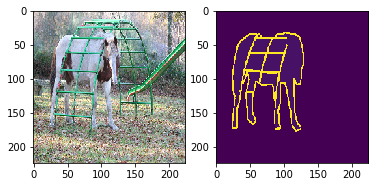

In [76]:
"""Pascal VOC Dataset Segmentation Dataloader"""


VOC_CLASSES = ('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')

NUM_CLASSES = len(VOC_CLASSES) + 1


class PascalVOCDataset(Dataset):
    """Pascal VOC 2007 Dataset"""
    def __init__(self, list_file, img_dir, mask_dir, transform=None):
        self.images = open(list_file, "rt").read().split("\n")[:-1]
        self.transform = transform

        self.img_extension = ".jpg"
        self.mask_extension = ".png"

        self.image_root_dir = img_dir
        self.mask_root_dir = mask_dir

        self.counts = self.__compute_class_probability()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        name = self.images[index]
        image_path = os.path.join(self.image_root_dir, name + self.img_extension)
        mask_path = os.path.join(self.mask_root_dir, name + self.mask_extension)

        image = self.load_image(path=image_path)
        gt_mask = self.load_mask(path=mask_path)

        data = {
                    'image': torch.FloatTensor(image),
                    'mask' : torch.LongTensor(gt_mask)
                    }

        return data

    def __compute_class_probability(self):
        counts = dict((i, 0) for i in range(NUM_CLASSES))

        for name in self.images:
            mask_path = os.path.join(self.mask_root_dir, name + self.mask_extension)

            raw_image = Image.open(mask_path).resize((224, 224))
            imx_t = np.array(raw_image).reshape(224*224)
            imx_t[imx_t==255] = len(VOC_CLASSES)

            for i in range(NUM_CLASSES):
                counts[i] += np.sum(imx_t == i)

        return counts

    def get_class_probability(self):
        values = np.array(list(self.counts.values()))
        p_values = values/np.sum(values)

        return torch.Tensor(p_values)

    def load_image(self, path=None):
        raw_image = Image.open(path)
        raw_image = np.transpose(raw_image.resize((224, 224)), (2,1,0))
        imx_t = np.array(raw_image, dtype=np.float32)/255.0

        return imx_t

    def load_mask(self, path=None):
        raw_image = Image.open(path)
        raw_image = raw_image.resize((224, 224))
        imx_t = np.array(raw_image)
        # border
        imx_t[imx_t==255] = len(VOC_CLASSES)

        return imx_t


data_root = "/tmp/voc2007/VOCdevkit/VOC2007"
list_file_path = os.path.join(data_root, "ImageSets", "Segmentation", "train.txt")
img_dir = os.path.join(data_root, "JPEGImages")
mask_dir = os.path.join(data_root, "SegmentationObject")

## Train
train_dataset = PascalVOCDataset(list_file=list_file_path,
                                    img_dir=img_dir,
                                    mask_dir=mask_dir)

## train_val 
list_file_path = os.path.join(data_root, "ImageSets", "Segmentation", "trainval.txt")

trainval_dataset = PascalVOCDataset(list_file=list_file_path,
                                    img_dir=img_dir,
                                    mask_dir=mask_dir)
## val
list_file_path = os.path.join(data_root, "ImageSets", "Segmentation", "val.txt")

val_dataset = PascalVOCDataset(list_file=list_file_path,
                                    img_dir=img_dir,
                                    mask_dir=mask_dir)

print(val_dataset.get_class_probability())

sample = val_dataset[7]
image, mask = sample['image'], sample['mask']

image.transpose_(0, 2)

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(image)

a = fig.add_subplot(1,2,2)
plt.imshow(mask)

plt.show()

In [0]:
def duplicateChannel(img):
        # Cette fonction permet de recopier 3 fois une image qui
        # ne serait que sur 1 channel (donc image niveau de gris)
        # pour la "transformer" en image RGB. Utilisez la avec
        # transform.Lambda
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img

device : cuda:0


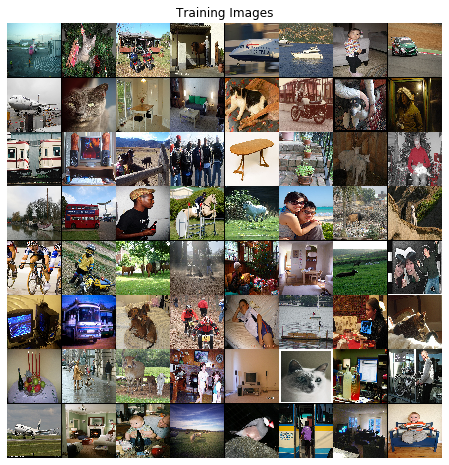

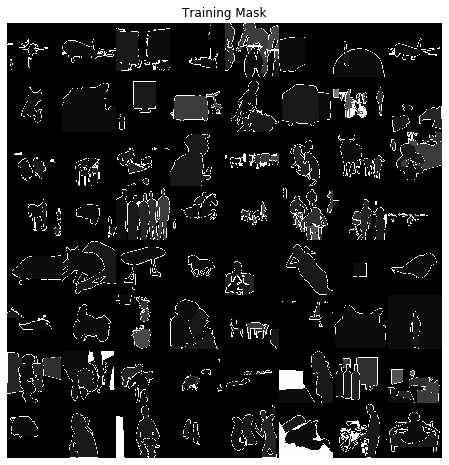

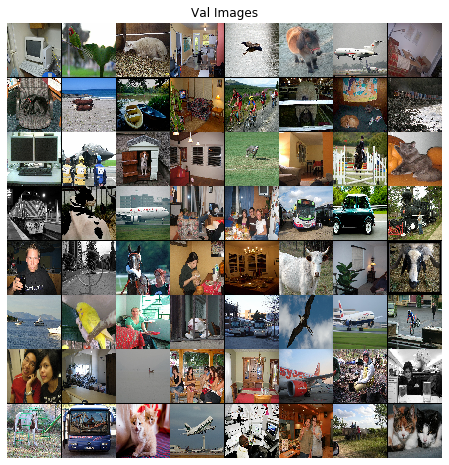

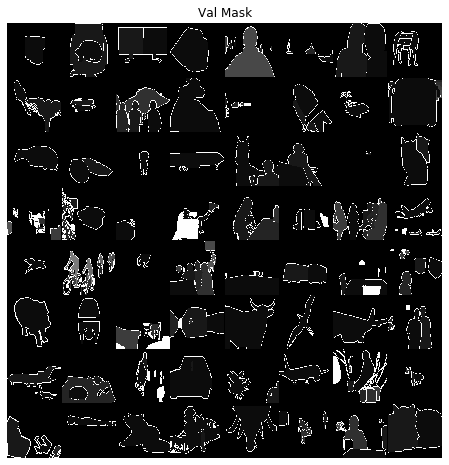

In [75]:

# Set batch_size
batch_size = 64

dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
dataloader_train_val = torch.utils.data.DataLoader(trainval_dataset, batch_size=batch_size)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :",device)

# Plot some training images
real_batch = next(iter(dataloader_train))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch['image'].float().to(device)[:64], padding=2, normalize=True).cpu()))
plt.show()

rb=torch.stack([real_batch['mask'],real_batch['mask'],real_batch['mask']],dim=1)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Mask")
plt.imshow(np.transpose(vutils.make_grid(rb.float().to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Plot some val images
real_batch = next(iter(dataloader_val))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Val Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch['image'].to(device)[:64], padding=2, normalize=True).cpu()))
plt.show()
rb=torch.stack([real_batch['mask'],real_batch['mask'],real_batch['mask']],dim=1)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Val Mask")
plt.imshow(np.transpose(vutils.make_grid(rb.float().to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## FCN for Semantic Segmentation models